# 数据挖掘互评作业二: 频繁模式与关联规则挖掘

07032001 刘益鸣 1120200650

## MIND 数据集

### 数据集获取与加载：来源于MIND官网提供的下载代码

In [1]:
import json
import os
import urllib
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from efficient_apriori import apriori
from dblp_parser import DBLP

In [2]:
# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = './MIND'
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [3]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [4]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['behaviors.tsv',
 'entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'relation_embedding.vec']

In [5]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_table = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
print(behaviors_table.shape)
behaviors_table.head(10)

(73152, 5)


,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
5,6,U69606,11/15/2019 1:24:44 PM,N879 N19591 N63054 N53033 N54088 N34140 N14952...,N29862-0 N48740-0 N11390-0 N5472-0 N53572-0 N2...
6,7,U70421,11/15/2019 5:12:12 AM,N38118 N55189 N16233 N37942 N23105 N27526 N965...,N42767-1 N30290-0 N36779-0 N20036-0 N32536-0 N...
7,8,U38418,11/15/2019 10:12:44 AM,N29464 N17952 N19028 N28338 N31631 N35831 N609...,N53687-0 N31289-0 N37458-0 N8455-0 N56211-0 N5...
8,9,U9568,11/15/2019 11:59:42 AM,N53393 N61857 N17744 N62644 N28274 N63634 N503...,N45612-0 N60939-1 N33397-0 N19685-0
9,10,U77860,11/15/2019 3:52:43 PM,N55829 N2203 N3909 N18459 N59704 N9146 N33096 ...,N29091-0 N60762-0 N29862-0 N512-0 N48740-0 N60...


In [6]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_table = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
print(news_table.shape)
news_table.head(10)

(42416, 8)


,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
5,N2073,sports,football_nfl,Should NFL be able to fine players for critici...,Several fines came down against NFL players fo...,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"":...","[{""Label"": ""National Football League"", ""Type"":..."
6,N11429,news,newsscienceandtechnology,"How to record your screen on Windows, macOS, i...",The easiest way to record what's happening on ...,https://assets.msn.com/labs/mind/AADlomf.html,"[{""Label"": ""Microsoft Windows"", ""Type"": ""J"", ""...",[]
7,N49186,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://assets.msn.com/labs/mind/AAJwoxD.html,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."
8,N2131,health,weightloss,This Guy Altered His Diet and Training to Drop...,"Take Brandon Reid's advice: ""Don't worry what ...",https://assets.msn.com/labs/mind/AAGBR44.html,[],[]
9,N59295,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,https://assets.msn.com/labs/mind/AAJ43pw.html,"[{""Label"": ""Chile"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Santiago"", ""Type"": ""G"", ""WikidataI..."


In [7]:
id_category_dict = {}
for i in range(news_table.shape[0]):
    id_category_dict[news_table['id'][i]] = (news_table['category'][i], news_table['subcategory'][i])
list(id_category_dict.items())[:10]

[('N55528', ('lifestyle', 'lifestyleroyals')),
 ('N18955', ('health', 'medical')),
 ('N61837', ('news', 'newsworld')),
 ('N53526', ('health', 'voices')),
 ('N38324', ('health', 'medical')),
 ('N2073', ('sports', 'football_nfl')),
 ('N11429', ('news', 'newsscienceandtechnology')),
 ('N49186', ('weather', 'weathertopstories')),
 ('N2131', ('health', 'weightloss')),
 ('N59295', ('news', 'newsworld'))]

展示所有分类及其子分类

In [8]:
category_dict = {}
for i in range(news_table.shape[0]):
    if news_table['category'][i] not in category_dict.keys():
        category_dict[news_table['category'][i]] = {news_table['subcategory'][i]}
    else:
        category_dict[news_table['category'][i]].add(news_table['subcategory'][i])
for key in category_dict.keys():
    print(f'{key}: {category_dict[key]}\n')

lifestyle: {'lifestylesmartliving', 'lifestylecareer', 'lifestylefamily', 'lifestyle', 'lifestylebeauty', 'lifestylediy', 'lifestylevideo', 'lifestylerelationships', 'travel', 'lifestylepets', 'lifestylewhatshot', 'shop-books-movies-tv', 'shop-all', 'lifestylefashion', 'lifestyle-wedding', 'pregnancyparenting', 'advice', 'lifestyleweddings', 'shop-apparel', 'lifestylehoroscopefish', 'lifestyleshoppinghomegarden', 'lifestylehomeandgarden', 'awardstyle', 'causes-green-living', 'shop-computers-electronics', 'lifestyleparenting', 'lifestyledecor', 'lifestyle-news-feature', 'causes-animals', 'lifestyleanimals', 'lifestylehoroscope', 'lifestylemarriage', 'relationships', 'lifestyleshopping', 'lifestylelovesex', 'lifestyleroyals', 'lifestyletravel', 'lifestylestyle', 'lifestylefamilyandrelationships', 'shop-home-goods', 'holidays', 'shop-holidays', 'lifestylebuzz', 'voices', 'causes', 'lifestylecleaningandorganizing', 'lifestyledidyouknow', 'lifestylepetsanimals', 'lifestylecelebstyle', 'life

In [9]:
behaviors_data = []
for i in range(behaviors_table.shape[0]):
    if behaviors_table['history'][i] is not np.nan and behaviors_table['impressions'][i] is not np.nan:
        history = behaviors_table['history'][i].split(' ')
        impressions = behaviors_table['impressions'][i].split(' ')
        for impression in impressions:
            if impression[-1] == '1':
                history.append(impression.split('-')[0])
    else:
        continue
    behaviors_data.append(history)

behaviors_data[4]

['N51692', 'N18285', 'N26015', 'N22679', 'N55556', 'N5940', 'N31958']

## 频繁模式挖掘

In [10]:
itemsets, rules = apriori(behaviors_data, min_support=0.005, min_confidence=0.5)

按大类别类

In [11]:
itemsets_category = dict()
for key, value in itemsets[2].items():
    new_key = (id_category_dict[key[0]][0], id_category_dict[key[1]][0])
    if new_key[0] > new_key[1]:
        new_key = (new_key[1], new_key[0])
    if new_key and new_key not in itemsets_category:
        itemsets_category[new_key] = value
    else:
        itemsets_category[new_key] += value
        
itemsets_category

{('news', 'news'): 226787,
 ('news', 'sports'): 106954,
 ('news', 'tv'): 176399,
 ('movies', 'news'): 76385,
 ('lifestyle', 'news'): 122080,
 ('finance', 'news'): 61103,
 ('autos', 'news'): 37405,
 ('lifestyle', 'tv'): 70061,
 ('movies', 'movies'): 6136,
 ('movies', 'tv'): 39044,
 ('autos', 'tv'): 15030,
 ('tv', 'tv'): 46099,
 ('entertainment', 'lifestyle'): 7728,
 ('news', 'video'): 14110,
 ('movies', 'video'): 3511,
 ('lifestyle', 'video'): 4924,
 ('sports', 'video'): 3969,
 ('tv', 'video'): 5366,
 ('autos', 'video'): 1057,
 ('autos', 'sports'): 12649,
 ('autos', 'movies'): 6557,
 ('autos', 'finance'): 7052,
 ('autos', 'lifestyle'): 10863,
 ('autos', 'autos'): 1138,
 ('autos', 'foodanddrink'): 4458,
 ('travel', 'video'): 392,
 ('movies', 'travel'): 1375,
 ('news', 'travel'): 5280,
 ('finance', 'travel'): 820,
 ('lifestyle', 'travel'): 1651,
 ('sports', 'travel'): 806,
 ('autos', 'travel'): 775,
 ('travel', 'tv'): 1628,
 ('video', 'weather'): 377,
 ('lifestyle', 'movies'): 28821,
 ('l

按频率从高到低展示

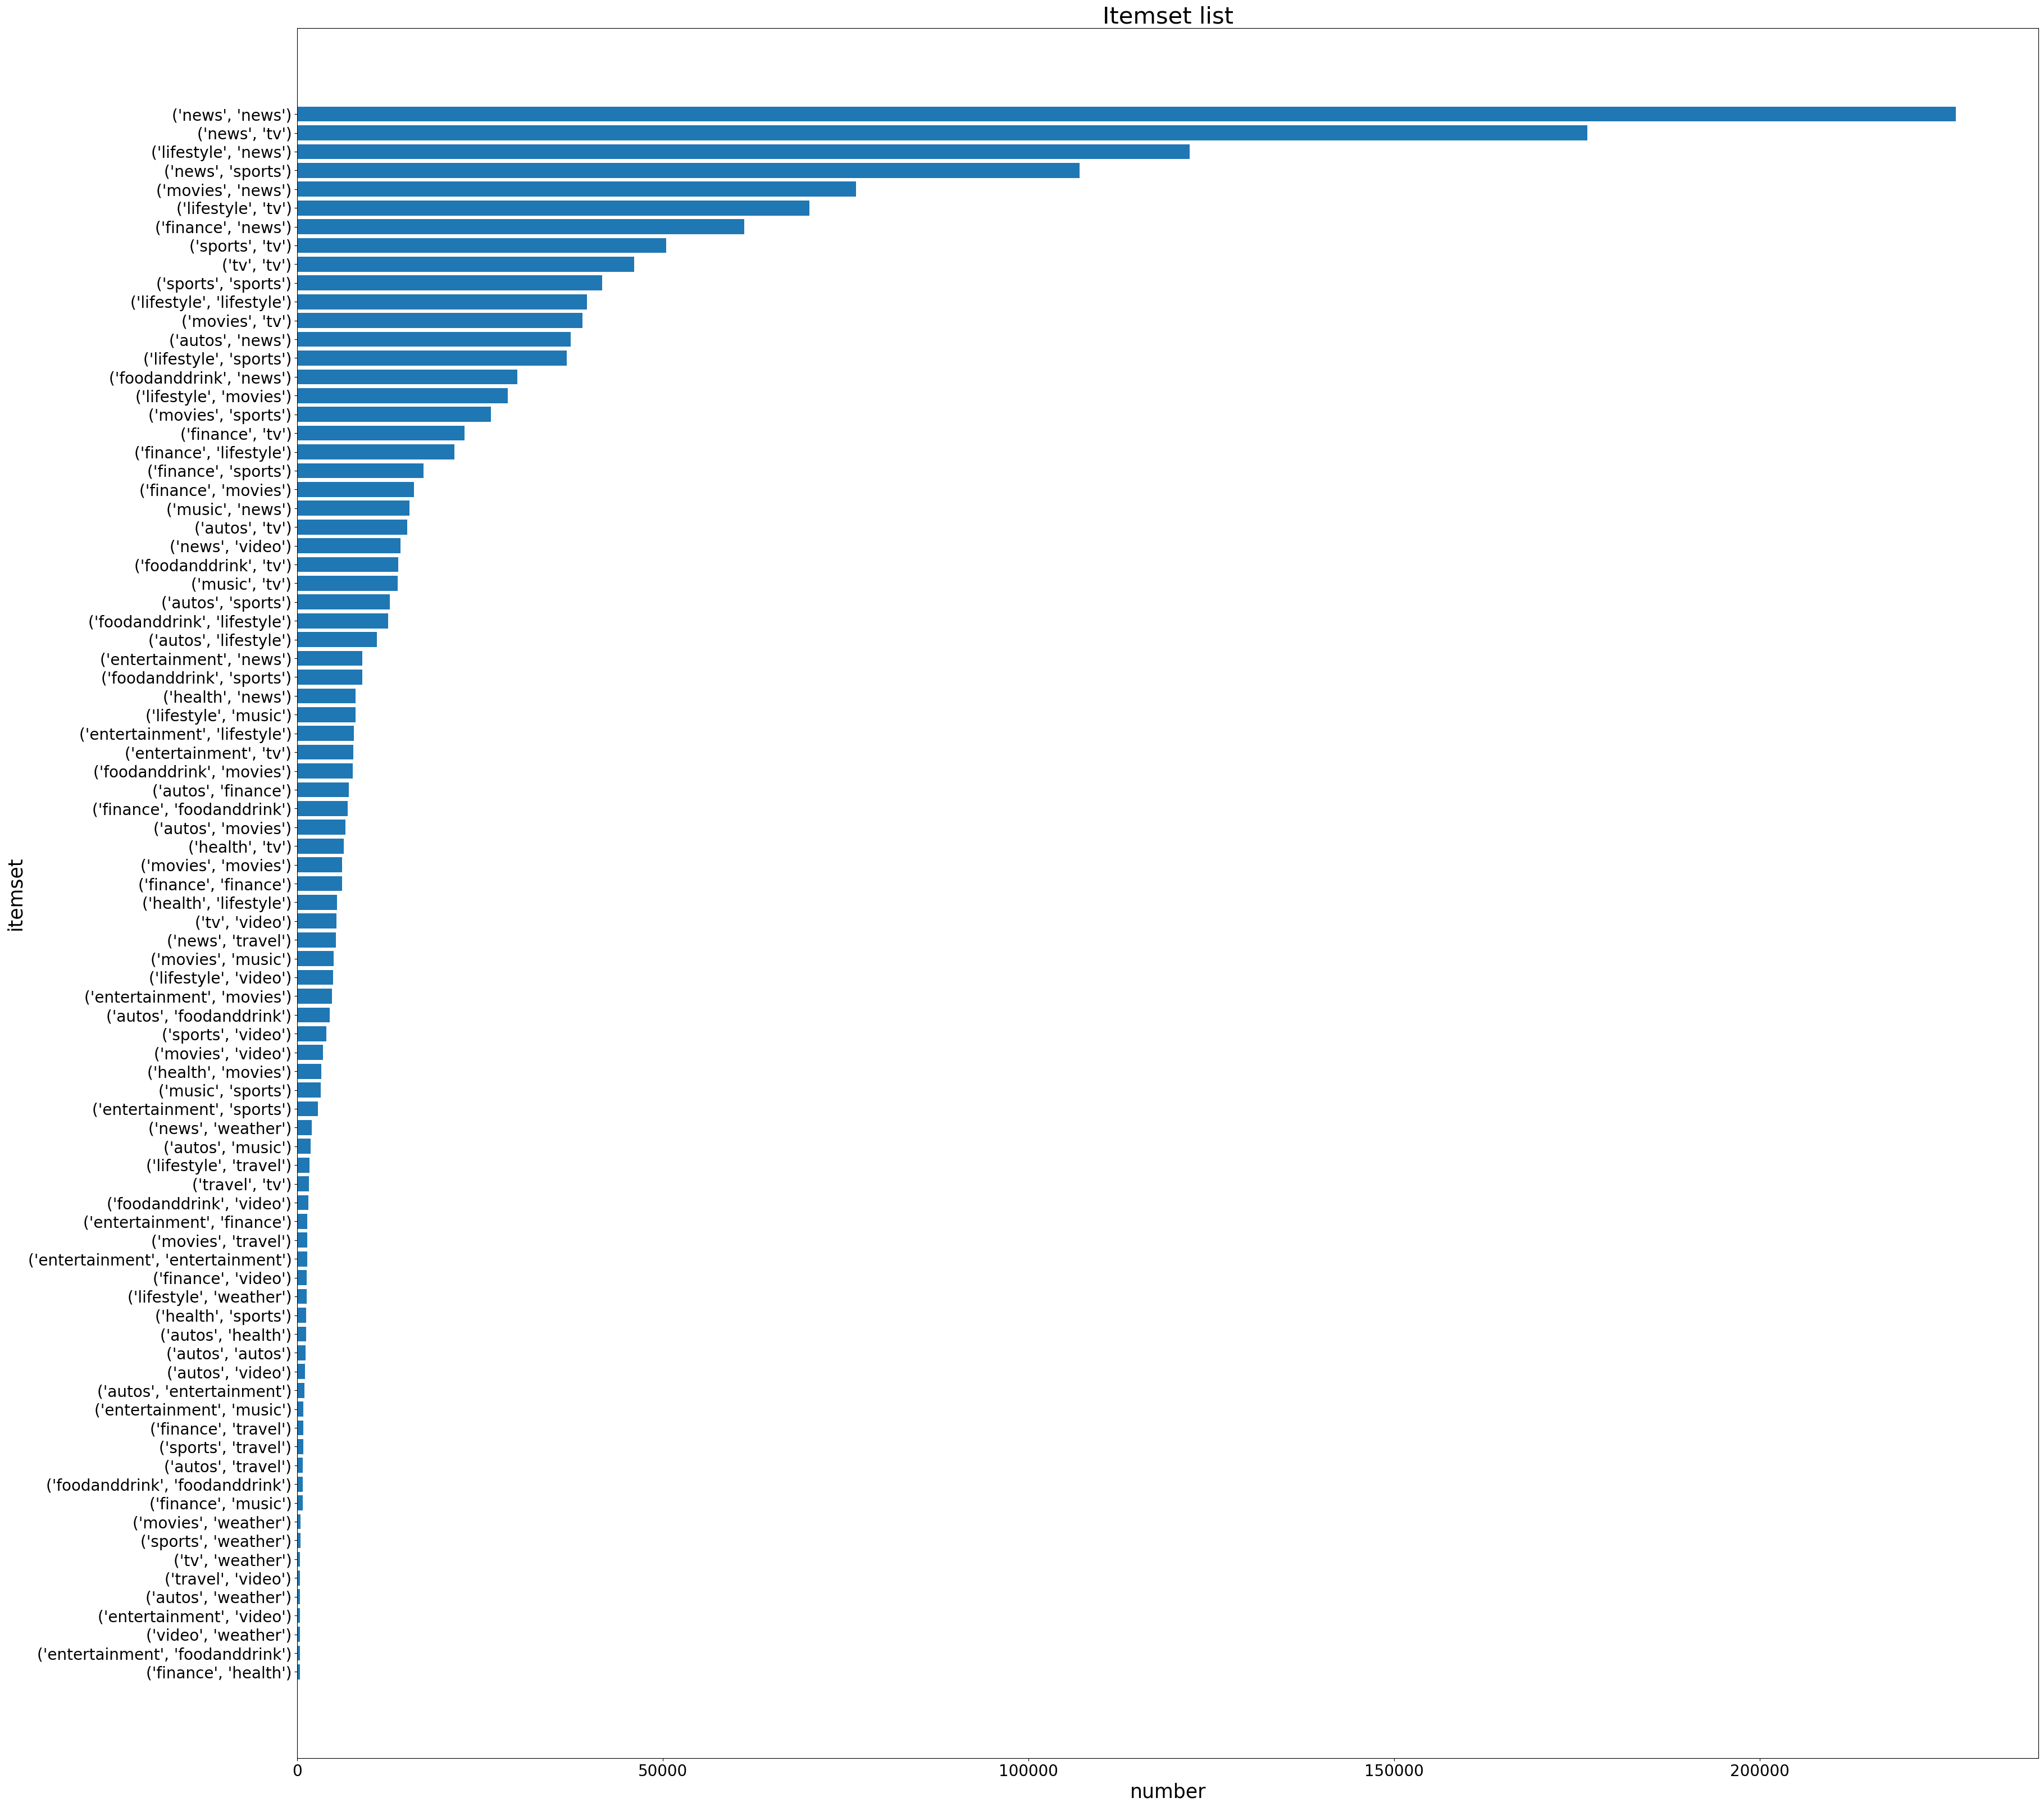

In [12]:
items = []
for key in itemsets_category.keys():
    items.append((str(key), itemsets_category[key]))
items = sorted(items, key=lambda x: x[-1])
items = np.array(items)
plt.figure(figsize=(40, 40))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.barh(items[:][:, 0], items[:][:, 1].astype('int'))
plt.ylabel('itemset', fontsize=25)
plt.xlabel(f'number', fontsize=25)
plt.title(f"Itemset list", fontsize=30, loc='center')
plt.show()

按子类别

In [13]:
itemsets_category = dict()
for key, value in itemsets[2].items():
    new_key = (id_category_dict[key[0]][1], id_category_dict[key[1]][1])
    if new_key[0] > new_key[1]:
        new_key = (new_key[1], new_key[0])
    if new_key and new_key not in itemsets_category:
        itemsets_category[new_key] = value
    else:
        itemsets_category[new_key] += value

itemsets_category

{('newscrime', 'newsus'): 79718,
 ('newsus', 'newsus'): 20251,
 ('newspolitics', 'newsus'): 20362,
 ('football_nfl', 'newsus'): 17795,
 ('newsus', 'tv-celebrity'): 50106,
 ('movies-celebrity', 'newsus'): 30783,
 ('lifestyleroyals', 'newsus'): 6142,
 ('finance-companies', 'newsus'): 5708,
 ('markets', 'newsus'): 11866,
 ('lifestylebuzz', 'newsus'): 27250,
 ('basketball_nba', 'newsus'): 12684,
 ('autosnews', 'newsus'): 13760,
 ('newsus', 'tvnews'): 13293,
 ('lifestylehomeandgarden', 'newsus'): 5138,
 ('boxing', 'newsus'): 1671,
 ('newsus', 'newsworld'): 6173,
 ('lifestylehomeandgarden', 'tv-celebrity'): 6001,
 ('movienews', 'movies-celebrity'): 371,
 ('movies-celebrity', 'tv-reviews'): 452,
 ('lifestylebuzz', 'tv-reviews'): 487,
 ('autosnews', 'tv-reviews'): 372,
 ('newscrime', 'tv-reviews'): 388,
 ('tv-reviews', 'tvnews'): 388,
 ('entertainment-celebrity', 'lifestylebuzz'): 3734,
 ('newspolitics', 'viral'): 3306,
 ('movies-celebrity', 'viral'): 1427,
 ('lifestylebuzz', 'viral'): 1453,
 

按频率从高到低展示前50

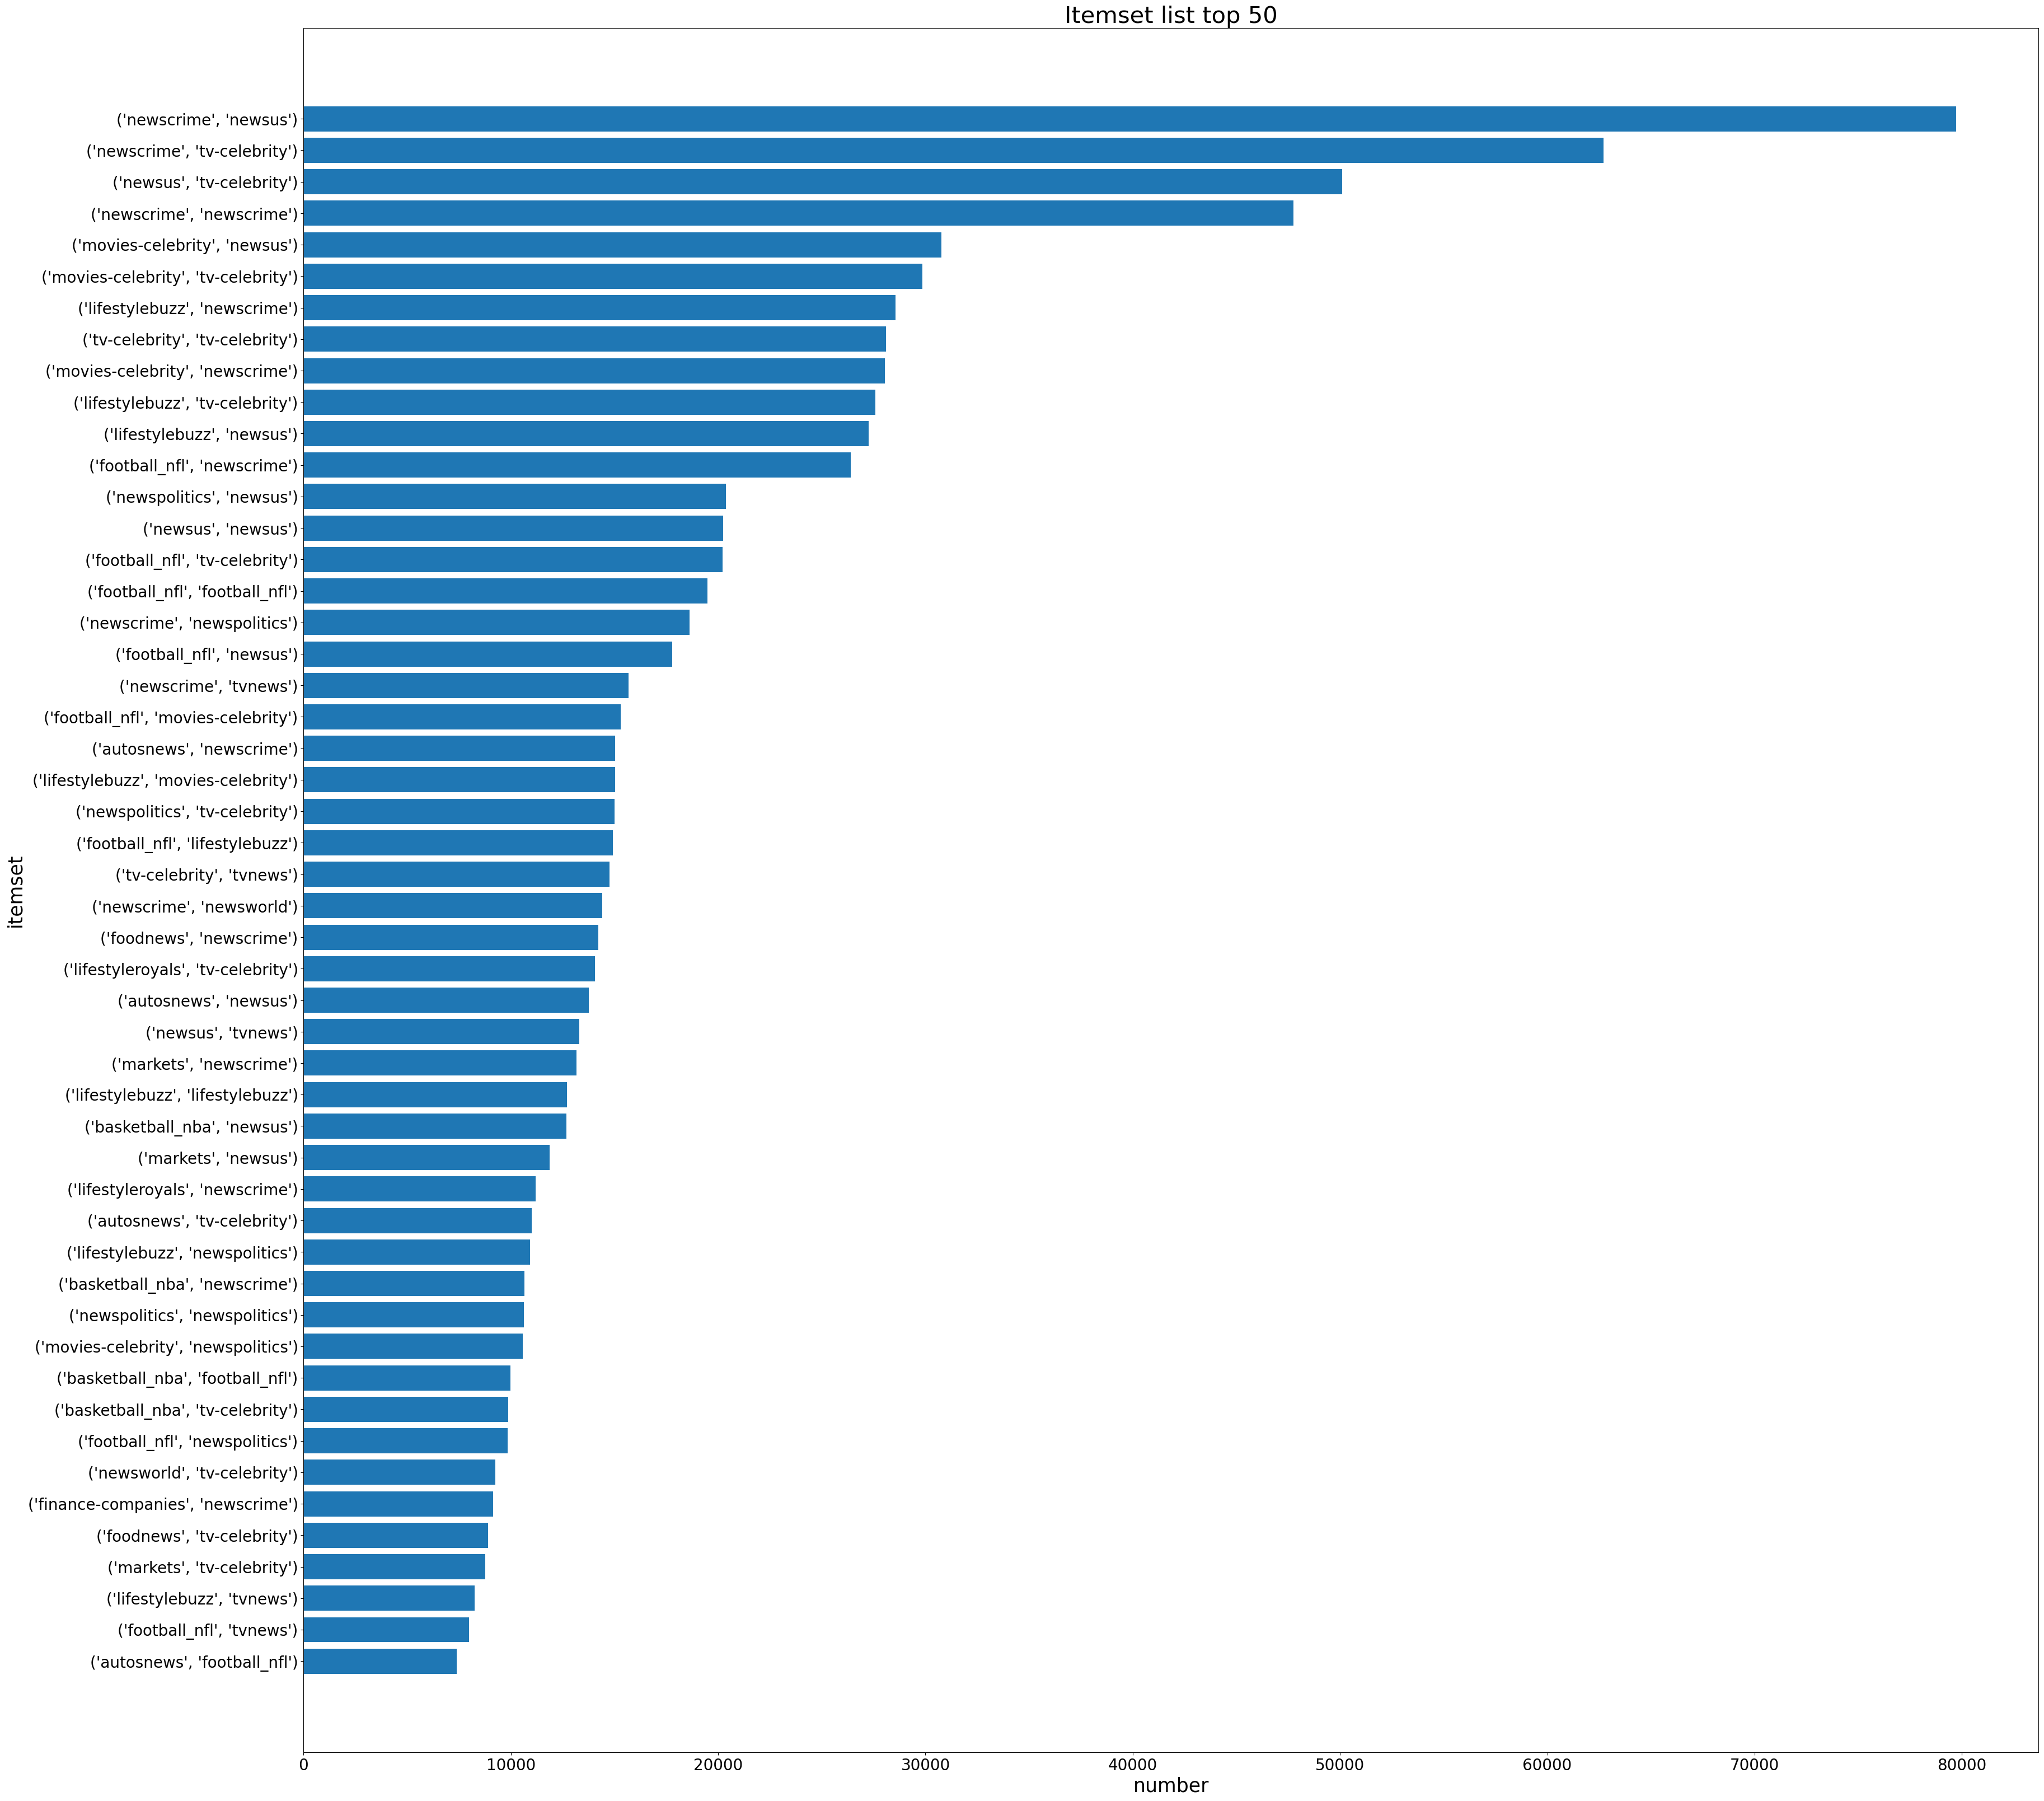

In [14]:
items = []
for key in itemsets_category.keys():
    items.append((str(key), itemsets_category[key]))
items = sorted(items, key=lambda x: x[-1])
items = np.array(items)
plt.figure(figsize=(40, 40))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.barh(items[-50:][:, 0], items[-50:][:, 1].astype('int'))
plt.ylabel('itemset', fontsize=25)
plt.xlabel(f'number', fontsize=25)
plt.title(f"Itemset list top 50", fontsize=30, loc='center')
plt.show()

## DBLP数据集

### 数据集预处理代码：https://github.com/angelosalatino/dblp-parser/blob/main/dblp_parser.py 将xml处理为json

In [15]:
dblp = DBLP()
dblp_path = "DBLP/dblp.xml.gz"
save_path = "DBLP/dblp.jsonl"
dblp.parse_all(dblp_path, save_path, features_to_extract=['author'])

2024-04-26 21:50:24 DBLP Successfully loaded "DBLP/dblp.xml.gz".
2024-04-26 21:50:24 DBLP Parsing all. Started.
2024-04-26 21:56:33 DBLP Parsing all. Finished.


In [16]:
dblp_data = []
with open(save_path, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        dblp_data.append(json.loads(line))
dblp_data[0]

{'type': 'article',
 'author': ['Paul Kocher',
  'Daniel Genkin',
  'Daniel Gruss',
  'Werner Haas 0004',
  'Mike Hamburg',
  'Moritz Lipp',
  'Stefan Mangard',
  'Thomas Prescher 0002',
  'Michael Schwarz 0001',
  'Yuval Yarom']}

In [17]:
author_dict = dict()
for data in dblp_data:
    for author in data['author']:
        if author not in author_dict:
            author_dict[author] = 1
        else:
            author_dict[author] += 1

items = []
for key in author_dict.keys():
    items.append((str(key), author_dict[key]))
items = sorted(items, key=lambda x: x[-1], reverse=True)

print(len(items))
items[:10]

3589949


[('H. Vincent Poor', 2890),
 ('Yang Liu', 2302),
 ('Philip S. Yu', 2113),
 ('Wei Wang', 2084),
 ('Yu Zhang', 2064),
 ('Wei Zhang', 2048),
 ('Mohamed-Slim Alouini', 2045),
 ('Dacheng Tao', 1910),
 ('Zhu Han 0001', 1824),
 ('Lajos Hanzo', 1806)]

In [18]:
items = np.array(items[:10000])
selected_authors = set(items[:, 0])
filtered_authors = []
for item in dblp_data:
    authors = set(item['author'])
    if len(authors.intersection(selected_authors)) != 0:
        filtered_authors.append(item['author'])
filtered_authors[0]

['Paul Kocher',
 'Daniel Genkin',
 'Daniel Gruss',
 'Werner Haas 0004',
 'Mike Hamburg',
 'Moritz Lipp',
 'Stefan Mangard',
 'Thomas Prescher 0002',
 'Michael Schwarz 0001',
 'Yuval Yarom']

## 频繁模式挖掘

In [19]:
itemsets, rules = apriori(filtered_authors, min_support=0.0001, min_confidence=0.1)

按频率从高到低展示

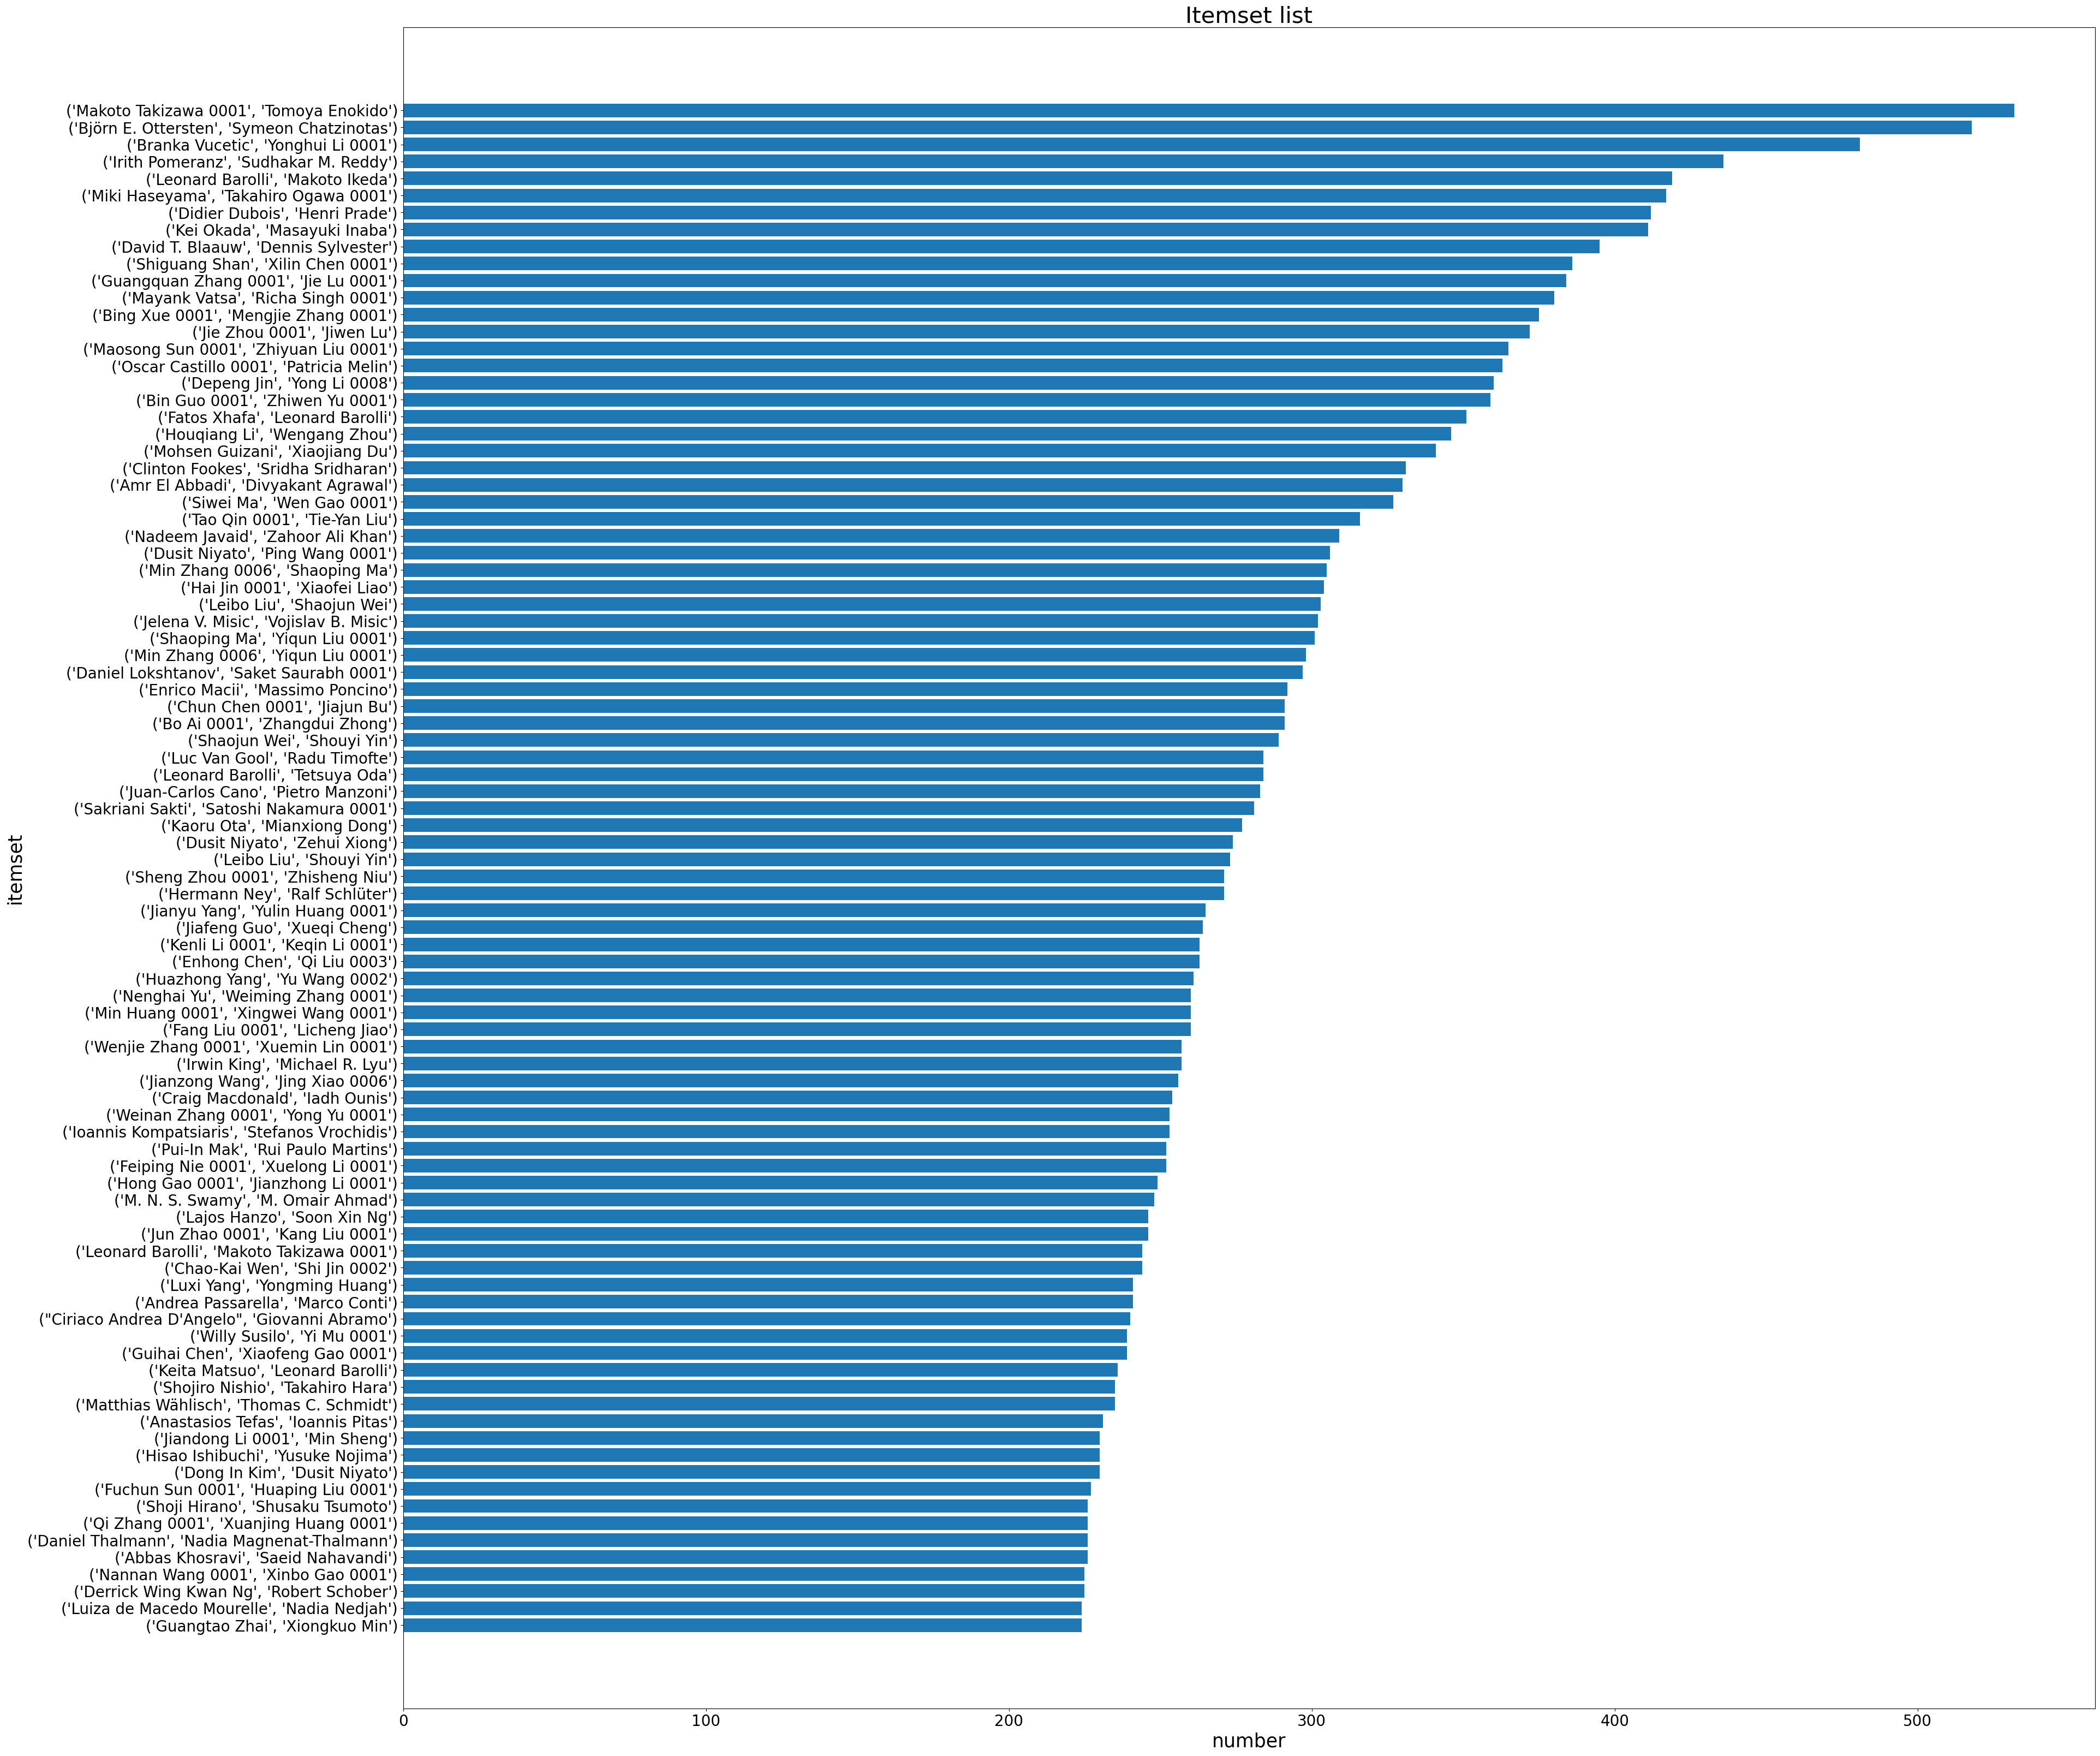

In [20]:
items = []
for key in itemsets[2].keys():
    items.append((str(key), itemsets[2][key]))
items = sorted(items, key=lambda x: x[-1])
items = np.array(items)
plt.figure(figsize=(40, 40))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.barh(items[:][:, 0], items[:][:, 1].astype('int'))
plt.ylabel('itemset', fontsize=25)
plt.xlabel(f'number', fontsize=25)
plt.title(f"Itemset list", fontsize=30, loc='center')
plt.show()